# 載入所需套件

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

#設定字體和解決圖像中文顯示問題
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus']=False

# 二項樹模型示意圖
![title](https://github.com/yyy855029/finance_practice/blob/master/%E6%9C%9F%E8%B2%A8%E9%81%B8%E6%93%87%E6%AC%8A%E7%9B%B8%E9%97%9C/%E4%B8%80%E8%88%AC%E5%8C%96%E4%BA%8C%E9%A0%85%E6%A8%B9%E6%A8%A1%E5%9E%8B/%E4%BA%8C%E9%A0%85%E6%A8%B9%E7%A4%BA%E6%84%8F%E5%9C%96.jpg)

# 定義到期報酬函數

In [2]:
def pay_off(S,K,name):
    pay_off_dict={'Call':lambda:np.maximum(S-K,0),
                  'Put':lambda:np.maximum(K-S,0)}
    
    return pay_off_dict.get(name)()

# 定義BS模型價格函數

In [3]:
def BSM_price(S,K,r,d,T,sigma,name):
    d1=(np.log(S/K)+(r-d+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    
    BSM_price_dict={'Call':lambda:S*np.exp(-d*T)*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2),
                    'Put':lambda:K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-d*T)*norm.cdf(-d1)}
    
    return BSM_price_dict.get(name)()

# 定義二項樹模型價格函數

In [4]:
def BinomialTree_price(kind,testTree):
    BinomialTree_price_dict={'European':lambda:testTree.roll_back_euro(pay_off),
                             'American':lambda:testTree.roll_back_amer(pay_off)}
    
    return BinomialTree_price_dict.get(kind)()

# 定義各種二項樹類別

In [5]:
class JarrowRuddTraits:
    @staticmethod
    def up(tree):
        return np.exp((tree.r-tree.d-0.5*tree.sigma*tree.sigma)*tree.dt+tree.sigma*np.sqrt(tree.dt))
    @staticmethod
    def down(tree):
        return np.exp((tree.r-tree.d-0.5*tree.sigma*tree.sigma)*tree.dt-tree.sigma*np.sqrt(tree.dt))
    @staticmethod
    def p(tree):
        return 0.5

class CRRTraits:
    @staticmethod
    def up(tree):
        return np.exp(tree.sigma*np.sqrt(tree.dt))
    @staticmethod
    def down(tree):
        return np.exp(-tree.sigma*np.sqrt(tree.dt))
    @staticmethod
    def p(tree):
        return ((np.exp((tree.r-tree.d)*tree.dt))-np.exp(-tree.sigma*np.sqrt(tree.dt)))/(np.exp(tree.sigma*np.sqrt(tree.dt))-np.exp(-tree.sigma*np.sqrt(tree.dt)))

# 定義二項樹框架類別

In [6]:
class BinomialTree:
    def __init__(self,S,K,r,d,n,T,sigma,tree_traits,name):
        self.dt=T/n
        self.S=S
        self.K=K
        self.r=r
        self.d=d
        self.n=n
        self.discount=np.exp(-self.r*self.dt)
        self.sigma=sigma
        self.up=tree_traits.up(self)
        self.down=tree_traits.down(self)
        self.p=tree_traits.p(self)
        self.q=1-self.p
        self.name=name
        self._build_lattice()
    
    def _build_lattice(self):
        self.lattice=np.zeros((self.n+1,self.n+1))
        self.lattice[0][0]=self.S
        #i:第幾層
        for i in range(self.n):
            #j:在i層中第幾個
            for j in range(i+1):
                self.lattice[i+1][j+1]=self.up*self.lattice[i][j]
            self.lattice[i+1][0]=self.down*self.lattice[i][0]
            
    def roll_back_euro(self,pay_off):
        for i in range(self.n,0,-1):
            for j in range(i,0,-1):
                #第n層(最後一層):計算pay_off的期望值
                if i==self.n:
                    self.lattice[i-1][j-1]=self.discount*(self.p*pay_off(self.lattice[i][j],self.K,self.name)+self.q*pay_off(self.lattice[i][j-1],self.K,self.name))
                else:
                    self.lattice[i-1][j-1]=self.discount*(self.p*self.lattice[i][j]+self.q*self.lattice[i][j-1])
        return self.lattice[0][0]
    
    def roll_back_amer(self,pay_off):
        for i in range(self.n,0,-1):
            for j in range(i,0,-1):
                if i==self.n:
                    euro_value=self.discount*(self.p*pay_off(self.lattice[i][j],self.K,self.name)+self.q*pay_off(self.lattice[i][j-1],self.K,self.name))
                else:
                    euro_value=self.discount*(self.p*self.lattice[i][j]+self.q*self.lattice[i][j-1])
                #處理是否提前履約
                exercise_value=pay_off(self.lattice[i-1][j-1],self.K,self.name)
                self.lattice[i-1][j-1]=np.maximum(euro_value,exercise_value)
        return self.lattice[0][0]

# 定義繪製二項樹算法收斂圖函數

In [7]:
def plot_BinomialTree(S,K,r,d,T,sigma,kind,name):
    n_range=np.arange(25,525,25)
    option_kind={'European':'歐式',
                 'American':'美式'}
    option_name={'Call':'買權',
                 'Put':'賣權'}
    jr_res=[]
    crr_res=[]

    for n in tqdm(n_range):
        #Jarrow-Rudd结果
        testTree=BinomialTree(S,K,r,d,n,T,sigma,JarrowRuddTraits,name)
        jr_price=BinomialTree_price(kind,testTree)
        jr_res.append(jr_price)
        #Cox-Ross-Rubinstein结果
        testTree=BinomialTree(S,K,r,d,n,T,sigma,CRRTraits,name)
        crr_price=BinomialTree_price(kind,testTree)
        crr_res.append(crr_price)

    ans_res=[BSM_price(S,K,r,d,T,sigma,name)]*len(n_range)

    
    fig,ax=plt.subplots(1,figsize=(10,5))
    ax.plot(n_range,jr_res,'-.',marker='o',markersize=5,label='Jarrow - Rudd') 
    ax.plot(n_range,crr_res,'-.',marker='d',markersize=5,label='Cox - Ross - Rubinstein') 
    ax.plot(n_range,ans_res,'--',label='Black - Schole - Merton')
    ax.set_title('{}{} 二項樹算法收歛性測試'.format(option_kind[kind],option_name[name]),fontsize=15)
    ax.set_xlabel('期數',fontsize=12)
    ax.set_ylabel('價格',fontsize=12)
    ax.legend()
    ax.grid()
    plt.show()

In [8]:
def plot_total_BinomialTree(S,K,r,d,T,sigma):
    n_range=np.arange(25,525,25)
    option_kind={'European':'歐式',
                 'American':'美式'}
    option_name={'Call':'買權',
                 'Put':'賣權'}
    kinds=['European','American']
    names=['Call','Put']

    
    fig,axes=plt.subplots(2,2,figsize=(10,6))
    for i,kind in tqdm(enumerate(kinds)):
        for j,name in enumerate(names):
            jr_res=[]
            crr_res=[]
            for n in n_range:
                #Jarrow-Rudd结果
                testTree=BinomialTree(S,K,r,d,n,T,sigma,JarrowRuddTraits,name)
                jr_price=BinomialTree_price(kind,testTree)
                jr_res.append(jr_price)
                #Cox-Ross-Rubinstein结果
                testTree=BinomialTree(S,K,r,d,n,T,sigma,CRRTraits,name)
                crr_price=BinomialTree_price(kind,testTree)
                crr_res.append(crr_price)

            ans_res=[BSM_price(S,K,r,d,T,sigma,name)]*len(n_range)
            
            axes[i,j].plot(n_range,jr_res,'-.',marker='o',markersize=5,label='Jarrow - Rudd') 
            axes[i,j].plot(n_range,crr_res,'-.',marker='d',markersize=5,label='Cox - Ross - Rubinstein') 
            axes[i,j].plot(n_range,ans_res,'--',label='Black - Schole - Merton')
            axes[i,j].set_title('{}{} 二項樹算法收歛性測試'.format(option_kind[kind],option_name[name]),fontsize=12)
            axes[i,j].set_xlabel('期數',fontsize=10)
            axes[i,j].set_ylabel('價格',fontsize=10)
            axes[i,j].legend(fontsize=10)
            axes[i,j].grid()
            plt.tight_layout()
    plt.show()

# 繪製歐式選擇權二項式算法收斂圖

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:07<00:00,  1.12it/s]


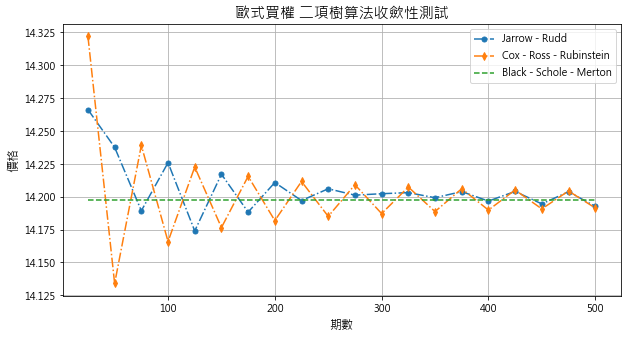

In [9]:
(S,K,r,d,T,sigma,kind,name)=(100,100,0.03,0.02,3,0.2,'European','Call')
plot_BinomialTree(S,K,r,d,T,sigma,kind,name)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:08<00:00,  1.09it/s]


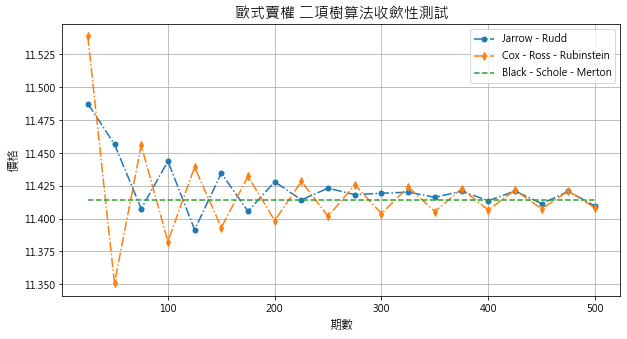

In [10]:
(S,K,r,d,T,sigma,K,kind,name)=(100,100,0.03,0.02,3,0.2,'European','Put')
plot_BinomialTree(S,K,r,d,T,sigma,kind,name)

# 繪製美式選擇權二項式算法收斂圖

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  3.48s/it]


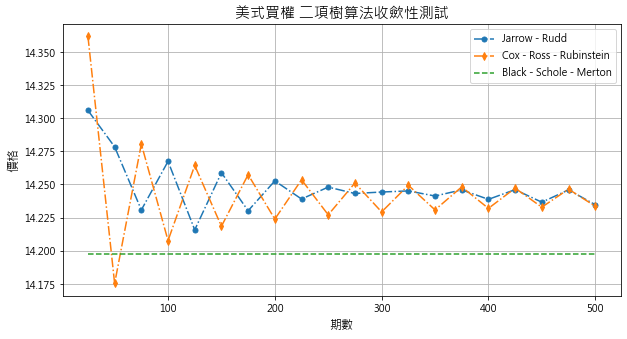

In [11]:
(S,K,r,d,T,sigma,K,kind,name)=(100,100,0.03,0.02,3,0.2,'American','Call')
plot_BinomialTree(S,K,r,d,T,sigma,kind,name)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  3.43s/it]


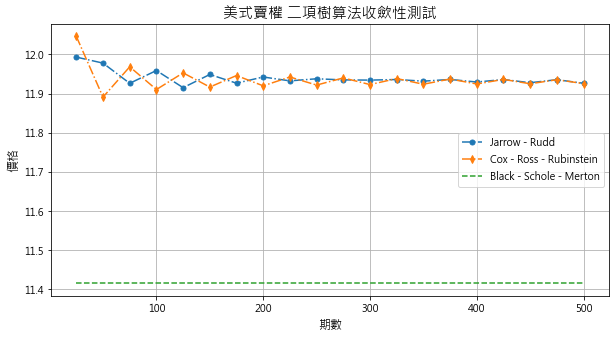

In [12]:
(S,K,r,d,T,sigma,K,kind,name)=(100,100,0.03,0.02,3,0.2,'American','Put')
plot_BinomialTree(S,K,r,d,T,sigma,kind,name)

2it [01:16, 29.53s/it]


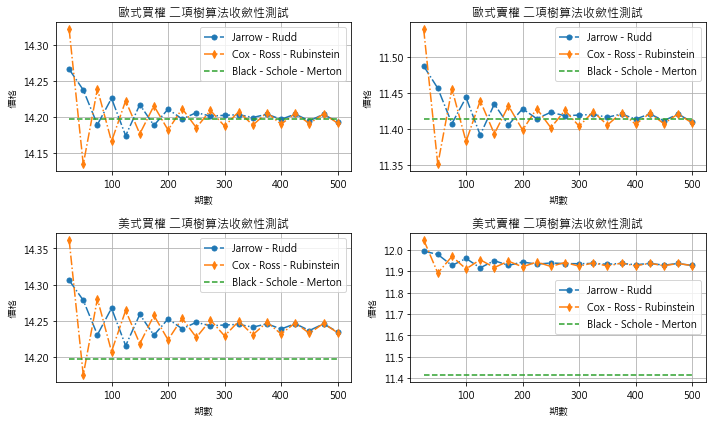

In [13]:
(S,K,r,d,T,sigma)=(100,100,0.03,0.02,3,0.2)
plot_total_BinomialTree(S,K,r,d,T,sigma)